# Author : Kartik B Bhargav

##  word2vec

**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 

Start by loading the necessary libraries.


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import keras.backend as K
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
print(tf.__version__) #  check what version of TF is imported

2.2.0-rc3


If you use Google Colab, you need to mount your Google Drive to the notebook when you want to use files that are located in your Google Drive. Paste the authorization code, from the new tab page that opens automatically when running the cell, in the cell below.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Navigate to the folder in which `alice.txt` is located. Make sure to start path with '/content/drive/My Drive/' if you want to load the file from your Google Drive.

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/DL course/'

/content/drive/My Drive/Colab Notebooks/DL course


In [0]:
# read the file 
file_name = 'alice.txt'
corpus = open(file_name).readlines()

In [0]:
corpus[:1]

['\n']

## Data Preprocessing

Before we can use the data in our SkipGram model, we need to convert each unique word to a unique numberic identifier. First we clean the data, where we remove punctuation from the text. Then a `Tokenizer` is fit on the cleaned corpus. This `Tokenizer` vectorizes a text corpus, by turning each sentence in the corpus into a sequence of integers.

In [0]:
# Removes sentences with fewer than 3 words
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# remove punctuation in text and fit tokenizer on entire corpus
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)

# convert text to sequence of integer values
corpus = tokenizer.texts_to_sequences(corpus)
n_samples = sum(len(s) for s in corpus) # total number of words in the corpus
V = len(tokenizer.word_index) + 1 # total number of unique words in the corpus + 1

In [0]:
corpus[:1]

[[305, 7, 38, 1, 92, 595]]

We add `1` to the number of unique words, such that we are also able to map  unknown words to one unique index value.  So, index `len(V)` corresponds to the unknown words that are not in the vocabulary, if you encouter those in future prediction tasks. We do not map unknown words to the index 0, because we want to be able to distinguish between a padded sequences (when you want to pad a sequence, you add zeros in front or at the end) and an unknown word that is not in the vocabulary. However, in this notebook we do not pad the sequence and we do not use words outside the vocabulary, so don't think about it too much for now.

In [0]:
n_samples, V

(27165, 2557)

In [0]:
# example of how word to integer mapping looks like in the tokenizer
print(list((tokenizer.word_index.items()))[:5])

[('the', 1), ('and', 2), ('to', 3), ('a', 4), ('it', 5)]


In [0]:
print(list((tokenizer.word_index.items()))[-5:])

[('gather', 2552), ('sorrows', 2553), ('joys', 2554), ('remembering', 2555), ('happy', 2556)]


## Generate data for Skipgram
Skipgram predicts the source context words given a target word. We break down each (target word, context word**s**) pair into a **single** pair (target word, context word). This is what we do in the function `generate_data_skipgram`, which returns two NumPy arrays: `x` (input, i.e. target word) and `y` (output, i.e. context word).

In [0]:
window_size = 2

In [0]:
corpus[:1]

[[305, 7, 38, 1, 92, 595]]

In [0]:
#generate data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Add the input word
                    #in_words.append(word)
                    all_in.append(word)
                    # Add one-hot of the context words
                    all_out.append(to_categorical(words[i], V))
                                      
    return (np.array(all_in),np.array(all_out))

In [0]:
x, y = generate_data_skipgram(corpus, window_size, V)

In [0]:
x.shape, y.shape

((94556,), (94556, 2557))

## Create architecture Skipgram model
Implement the Skipgram model architecture. 

* Initialise a Keras Sequential model
* Add an Embedding layer. Think about the following parameter values: the input dimension (`input_dim`) , the size of the embedding vectors (`output_dim`) and the input length (`input_length`). Use the parameter `kernel_initializer` to initialize the weights with values from a `glorot_uniform` distribution. An embedding layer turns positive integers into a dense vector of size `dim`. This embedding layer learns a dense word embedding for all words in the vocabulary.
* Add a Reshape layer, which reshapes the output of the embedding layer (1,dim) to (dim,)
* Add a final Dense layer with the same size and activation function as in [1]. Use the parameter `kernel_initializer` to initialize the weights with values from a `glorot_uniform` distribution.
* Compile the model with a suitable loss function and select an optimizer.

In [0]:
dim = 100 # dimension of word embedding

# TODO finish the model implementation
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(V, kernel_initializer='glorot_uniform', activation='softmax'))
skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

The `?` in the output of `plot_model` corresponds to the batch size.

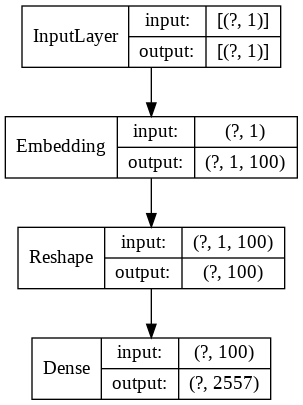

In [0]:
plot_model(skipgram, show_shapes = True, show_layer_names=False)

In [0]:
skipgram.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 100)            255700    
_________________________________________________________________
reshape (Reshape)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2557)              258257    
Total params: 513,957
Trainable params: 513,957
Non-trainable params: 0
_________________________________________________________________


<b>HINT</b>: To increase training speed of your model, you can use the free available GPU power in Google Colab. Go to `Edit` --> `Notebook Settings` --> select `GPU` under `hardware accelerator`.

In [0]:
# TODO train the skipgram model

skipgram.fit(x, y, batch_size=64, epochs=10, verbose=1)

Epoch 1/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8461
Epoch 2/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8452
Epoch 3/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8444
Epoch 4/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8435
Epoch 5/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8427
Epoch 6/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8419
Epoch 7/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8410
Epoch 8/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8401
Epoch 9/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8393
Epoch 10/10
1478/1478 [==============================] - 5s 3ms/step - loss: 7.8384


## Get word embeddings
The embedding matrix is saved in the weights of the model. 

In [0]:
weights = skipgram.get_weights()

print("Weights for the embedding layer: ",  weights[0].shape)
print("Weights for the dense layer: ",  weights[1].shape)
print("Biases for the dense layer: ",  weights[2].shape)

Weights for the embedding layer:  (2557, 100)
Weights for the dense layer:  (100, 2557)
Biases for the dense layer:  (2557,)


In [0]:
# Get the embedding matrix
embedding = weights[0]

In [0]:
# get word embeddings for each word in the vocabulary, write to file

f = open('vectors_skipgram.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(embedding[i,:]))))
    f.write("\n")
f.close()

## Analogy function and performance comparison

Now that the model is trained, we can get the word embedding for each word in the vocabulary. We can perform an analogy task (see [1] for concrete examples), by adding and subtracting the embedding of words from each other. In the code below we use the Euclidean distance metric to compute the distane between the predicted embedding and the true word embedding, however other distance metrices can also be used. 

To get the word embedding $e_{word}$, we take the dot product of the one-hot encoding of the word and the embedding matrix, i.e. $e_{word} = E_{embedding} \cdot V_{one-hot-word}$ (see also the lecture notes).

In [0]:
# Embed a word by getting the one hot encoding and taking the dot product of this vector with the embedding matrix
# 'word' = string type
def embed(word, embedding=embedding, vocab_size = V, tokenizer=tokenizer):
    # get the index of the word from the tokenizer, i.e. convert the string to it's corresponding integer in the vocabulary
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the one-hot encoding of the word
    bin_word = to_categorical(int_word, V)
    return np.dot(bin_word, embedding)

We can check whether an analogy function like $e_{king} - e_{queen} + e_{woman} \approx e_{man}$ holds. In a perfect scenario, we would like that this formula ( $e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$. We only compute the distance between the predicted embedding and the embedding of the true word. 

In [0]:
# TODO: compute the embedding by implementing the formula above. Use the embed function to get an embedding of a word
predictedEmbedding = embed('king') - embed('queen') + embed('woman') # expected embedding = e_man

Compute the distance between expectedEmbedding and the embedding of the true word `man`.

In [0]:
# TODO: compute distance between the predicted embedding and the true word embedding using the Euclidean distance metric
dist_exp_true = np.linalg.norm(predictedEmbedding - embed('man'))
print(dist_exp_true)

0.5869373


We can use the distance metric to find if the expected word is equal to the actual word.  If the expected word embedding is the same as the word embedding of the true word, the model made a correct prediction.